In [17]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt

1. Definir a cécula computacional (região de simulação)
2. Definir os materiais
3. Definir a geometria
4. Definir as fontes ópticas
5. Definir as condições de contorno
6. Definir os monitores de campo
7. Criar os objetos de simulação

### Parâmetros de simulação

In [18]:
resolution = 10 # 10 um/pixels which corresponds to around 67 pixels/wavelength, or around 20 pixels/wavelength in the high-index material

sx = 16  # size of cell in X direction
sy = 8   # size of cell in Y direction

pad = 4  # padding distance between waveguide and cell edge
w   = 1  # width of waveguide

dpml = 1.0

wvg_xcen =  0.5*(sx-w-2*pad)  # x center of horiz. wvg
wvg_ycen = -0.5*(sy-w-2*pad)  # y center of vert. wvg

# 0.15 corresponds to a vacuum wavelength of about 1/0.15=6.67 μm or ~2 μm for Si
# The current is located at (-7,0), which is 1 μm to the right of the left edge of the cell
fcen = 0.15  # pulse center frequency
df = 0.1     # pulse width (in frequency)
nfreq = 100  # number of frequencies at which to compute flux

### Definir a cécula computacional (região de simulação)

In [19]:
cell = mp.Vector3(sx, sy, 0) # (x, y, z) size in um -> 16 um x 8 um (2D)

### Definir os materiais

In [20]:
from meep.materials import Si

### Definir a geometria

In [21]:
geometry = [mp.Block(size=mp.Vector3(mp.inf,w,mp.inf),
                     center=mp.Vector3(0,wvg_ycen,0),
                      material=mp.Medium(epsilon=12))]

### Definir as fontes ópticas

In [22]:
sources = [mp.Source(mp.ContinuousSource(fcen,fwidth=df),
                     component=mp.Ez,
                     center=mp.Vector3(-0.5*sx+dpml,wvg_ycen,0),
                     size=mp.Vector3(0,w,0))]

# 0.15 corresponds to a vacuum wavelength of about 1/0.15=6.67 μm or ~2 μm for Si
# The current is located at (-7,0), which is 1 μm to the right of the left edge of the cell
#sources = [mp.Source(mp.ContinuousSource(frequency=0.15),
#                     component=mp.Ez,
#                     center=mp.Vector3(-7,0))]

### Definir as condições de contorno

In [23]:
## To add an absorbing layer of thickness 1 μm around all sides of the cell
pml_layers = [mp.PML(dpml)] ## PML layers on all axis
# pml_layers = [mp.PML(thickness=dpml,direction=mp.X)] ## PML layers on x axis

### Criar os objetos de simulação

In [24]:
sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=sources,
                    resolution=resolution)

In [25]:
# reflected flux
refl_fr = mp.FluxRegion(center=mp.Vector3(-0.5*sx+dpml+0.5,wvg_ycen,0), size=mp.Vector3(0,2*w,0))
refl = sim.add_flux(fcen, df, nfreq, refl_fr)

# transmitted flux
tran_fr = mp.FluxRegion(center=mp.Vector3(0.5*sx-dpml,wvg_ycen,0), size=mp.Vector3(0,2*w,0))
tran = sim.add_flux(fcen, df, nfreq, tran_fr)

In [26]:
pt = mp.Vector3(0.5 * sx - dpml - 0.5, wvg_ycen)

     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)


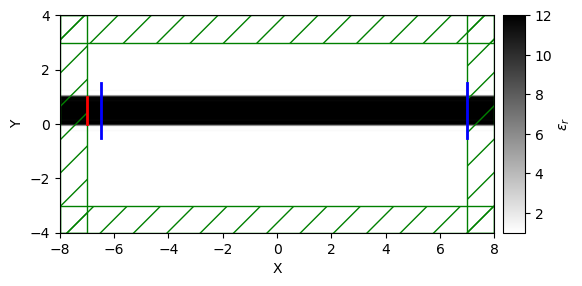

In [27]:
f = plt.figure(dpi=100)
sim.plot2D(
    ax=f.gca(),
    eps_parameters={"colorbar":True}
    )
plt.show()

In [28]:
sim.run(until=200)

-----------
Initializing structure...
time for choose_chunkdivision = 9.98974e-05 s
Working in 2D dimensions.
Computational cell is 16 x 8 x 0 with resolution 10
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.020962 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (4000 timesteps)


### Results

     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)


<AxesSubplot:xlabel='X', ylabel='Y'>

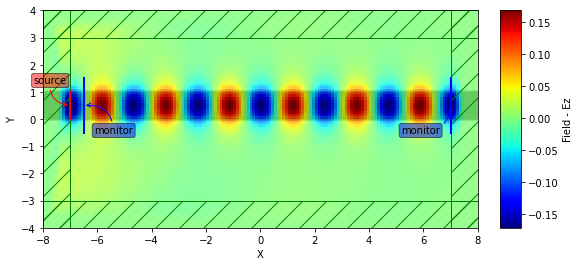

In [29]:
def field_func(x):
    return np.real(x)
field_parameters={
    "alpha": 0.8,
    "cmap": "jet",
    "interpolation": "none",
    "post_process": field_func,
    "colorbar":True,
}
monitor_parameters={
    "offset":30,
    "label_alpha":0.5,
    "label_color":'blue',
}
source_parameters={
    "offset":-20,
    "label_alpha":0.5,
    "label_color":'red',
}
colorbar_parameters={
    "label":'Field - Ez',
    "orientation":'vertical',
    "extend":'neither',
    "format":None,
    "position":'right',
    "size":'5%',
    "pad":'5%',
}
fig=plt.figure(figsize=(12,4))
sim.plot2D(
    output_plane=mp.Volume(center=mp.Vector3(0,0,0), size=mp.Vector3(16,16,0)),
    labels='Teste',
    monitor_parameters=monitor_parameters,
    source_parameters=source_parameters,
    fields=mp.Ez,
    field_parameters=field_parameters,
    colorbar_parameters=colorbar_parameters)

     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)


<AxesSubplot:xlabel='X', ylabel='Y'>

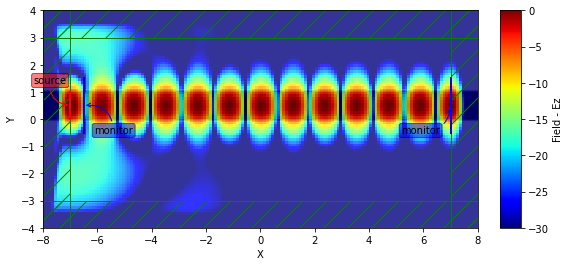

In [30]:
def field_func_dB(x):
    x_dB = 10*np.log10(x*np.conjugate(x))
    x_norm = x_dB - x_dB.max()
    x_norm[np.where(x_norm < -30)] = -30
    return x_norm
field_parameters={
    "alpha": 0.8,
    "cmap": "jet",
    "interpolation": "none",
    "post_process": field_func_dB,
    "colorbar":True,
}
colorbar_parameters={
    "label":'Field - Ez',
    "orientation":'vertical',
    "extend":'neither',
    "format":None,
    "position":'right',
    "size":'5%',
    "pad":'5%',
}
fig=plt.figure(figsize=(12,4))
sim.plot2D(
    output_plane=mp.Volume(center=mp.Vector3(0,0,0), size=mp.Vector3(16,16,0)),
    labels='Teste',
    monitor_parameters=monitor_parameters,
    source_parameters=source_parameters,
    fields=mp.Ez,
    field_parameters=field_parameters,
    colorbar_parameters=colorbar_parameters)